In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random

In [2]:
# Composite DP Mechanism (1) [https://github.com/CompositeDP/CompositeDP]

def float3f(num):
    return float(format(num, '.3f'))


def float2f(num):
    return float(format(num, '.2f'))


# Constraints

def LValue(ep, k, m, y):
    return (1 - k * m) / (2 * y)

def aValue(ep, k, m, y, Cp):
    return (2 * Cp - k * m ** 2) / (2 * k * m)

def checkConstraints(ep, k, m, y, Cp):
    if k <= 0:
        return -1
    if m <= 0:
        return -2
    if y <= 0:
        return -3

    L = LValue(ep, k, m, y)
    a = aValue(ep, k, m, y, Cp)

    if k * m >= 1:
        return -4
    if (Cp > k * m * (2 * L - m) / 2) or (Cp < -k * m * (2 * L - m) / 2):
        return -5
    if k > 1 - y:
        return -6
    if k > y * (np.e ** ep - 1):
        return -7
    
    return 0


# Mapping

def range_Cp_fun(ep, k, m, y):
    L = LValue(ep, k, m, y)
    return k * m * (2 * L - m)

def mapping_fromRealToL(input_value, range_f, lower, ep, k, m, y):
    L = LValue(ep, k, m, y)
    range_Cp = range_Cp_fun(ep, k, m, y)
    C = range_Cp / range_f
    mapped_value = (input_value - lower) * C - L

    return mapped_value

def mapping_inverse_fromLToReal(input_value, range_f, lower, ep, k, m, y):
    L = LValue(ep, k, m, y)
    range_Cp = range_Cp_fun(ep, k, m, y)
    C = range_Cp / range_f
    mapped_inverse_value = (input_value + L) / C + lower

    return mapped_inverse_value

def listmapping_inverse_fromLToReal(input_list, range_f, lower, ep, k, m, y):
    mapped_inverse_list = []
    for i in range(len(input_list)):
        tmp = mapping_inverse_fromLToReal(input_list[i], range_f, lower, ep, k, m, y)
        mapped_inverse_list.append(tmp)
    return mapped_inverse_list


# Parameter Optimization

def reduceRate(var1, var2):
    rate = (var1 - var2) / var1
    return float(rate)

def H1Rate(ep, k, m, y):
    L = LValue(ep, k, m, y)
    S1 = k*m; S2 = 2*L*y
    return float(S2 / S1)

def H2Rate(Cp, ep, k, m, y):
    L = LValue(ep, k, m, y)
    return 0.33333

def theory_var_fun(ep, k, m, y, Cp_assume):
    Cp = Cp_assume
    L = LValue(ep, k, m, y)
    a = aValue(ep, k, m, y, Cp)
    variance = -Cp ** 2 + 2 * L ** 3 * y / 3 + a ** 2 * k * m + a * k * m ** 2 + k * m ** 3 / 3
    return float(variance)

def parameter_optimization(ep):
    step1 = 0.1
    step2 = 0.01
    step3 = 0.001
    k_best = 0
    m_best = 0
    y_best = 0
    reduceRate_best = -1000

    y_upper = 1
    k_upper = 1
    m_upper = 2

    # First round step1
    y_count = 0
    while (y_count < y_upper):
        k_count = 0
        while (k_count < k_upper):
            m_count = 0
            while (m_count <= m_upper):
                if y_count == 0:
                    m_count = m_count + step1
                    continue
                range_Cp = range_Cp_fun(ep, k_count, m_count, y_count)
                # Cp_assume = range_Cp / 2
                Cp_assume = 0
                if (checkConstraints(ep, k_count, m_count, y_count, Cp_assume) == 0):
                    var_tmp = theory_var_fun(ep, k_count, m_count, y_count, Cp_assume)
                    var_lap = (range_Cp / ep) ** 2 * 2
                    reduceRate_tmp = reduceRate(var_lap, var_tmp)

                    if (reduceRate_tmp > reduceRate_best):
                        reduceRate_best = reduceRate_tmp
                        k_best = k_count
                        m_best = m_count
                        y_best = y_count

                m_count = m_count + step1
            k_count = k_count + step1
        y_count = y_count + step1

    # Second round step2
    if (y_best == 0):
        y_count = 0
        y_count_end = 0.1
    else:
        y_count = y_best - step1
        y_count_end = y_best + step1
    while (y_count < y_count_end):
        if (k_best == 0):
            k_count = 0
            k_count_end = 0.1
        else:
            k_count = k_best - step1
            k_count_end = k_best + step1
        while (k_count < k_count_end):
            if (m_best == 0):
                m_count = 0
                m_count_end = 0.1
            else:
                m_count = m_best - step1
                m_count_end = m_best + step1
            while (m_count < m_count_end):
                if y_count == 0:
                    m_count = m_count + step2
                    continue
                range_Cp = range_Cp_fun(ep, k_count, m_count, y_count)
                # Cp_assume = range_Cp / 2
                Cp_assume = 0
                if (checkConstraints(ep, k_count, m_count, y_count, Cp_assume) == 0):
                    var_tmp = theory_var_fun(ep, k_count, m_count, y_count, Cp_assume)
                    var_lap = (range_Cp / ep) ** 2 * 2
                    reduceRate_tmp = reduceRate(var_lap, var_tmp)

                    if (reduceRate_tmp > reduceRate_best):
                        reduceRate_best = reduceRate_tmp
                        k_best = k_count
                        m_best = m_count
                        y_best = y_count

                m_count = m_count + step2
            k_count = k_count + step2
        y_count = y_count + step2

    # Third round step3
    if (y_best == 0):
        y_count = 0
        y_count_end = 0.01
    else:
        y_count = y_best - step2
        y_count_end = y_best + step2
    while (y_count < y_count_end):
        if (k_best == 0):
            k_count = 0
            k_count_end = 0.01
        else:
            k_count = k_best - step2
            k_count_end = k_best + step2
        while (k_count < k_count_end):
            if (m_best == 0):
                m_count = 0
                m_count_end = 0.01
            else:
                m_count = m_best - step2
                m_count_end = m_best + step2
            while (m_count < m_count_end):
                if y_count == 0:
                    m_count = m_count + step3
                    continue
                range_Cp = range_Cp_fun(ep, k_count, m_count, y_count)
                # Cp_assume = range_Cp / 2
                Cp_assume = 0
                if (checkConstraints(ep, k_count, m_count, y_count, Cp_assume) == 0):
                    var_tmp = theory_var_fun(ep, k_count, m_count, y_count, Cp_assume)
                    var_lap = (range_Cp / ep) ** 2 * 2
                    reduceRate_tmp = reduceRate(var_lap, var_tmp)

                    if (reduceRate_tmp > reduceRate_best):
                        reduceRate_best = reduceRate_tmp
                        k_best = k_count
                        m_best = m_count
                        y_best = y_count

                m_count = m_count + step3
            k_count = k_count + step3
        y_count = y_count + step3

    return k_best, m_best, y_best


# Perturbation Mechanism

def PDF_fun(x, ep, k, m, y, Cp):
    L = LValue(ep, k, m, y)
    a = aValue(ep, k, m, y, Cp)
    P = 0
    if (x >= -L) and (x < a):
        P = y
    if (x >= a) and (x < a + m):
        P = y + k
    if (x >= a + m) and (x <= L):
        P = y
    return float3f(P)

def generate_perturbed_list(ep, k, m, y, Cp):
    L = LValue(ep, k, m, y)
    a = aValue(ep, k, m, y, Cp)
    t = (y + k) / np.e ** ep

    divid = 10000
    step = 2 * L / divid
    x_count = -L
    X_axis = []
    P_axis = []
    Perturbed_list = []

    while (x_count <= L):
        P_x = PDF_fun(x_count, ep, k, m, y, Cp)
        P_axis.append(P_x)
        X_axis.append(x_count)
        x_count = x_count + step

    for i in range(len(X_axis)):
        rp = P_axis[i]
        rp = int(rp * 1000)
        for j in range(rp):
            Perturbed_list.append(X_axis[i])

    random.shuffle(Perturbed_list)
    return Perturbed_list

def CDPM(ep, fd, range_f, lower):
    k_best, m_best, y_best = parameter_optimization(ep)
    Cp = mapping_fromRealToL(fd, range_f, lower, ep, k_best, m_best, y_best)
    O_perturbed = generate_perturbed_list(ep, k_best, m_best, y_best, Cp)
    Out_perturbed = listmapping_inverse_fromLToReal(O_perturbed, range_f, lower, ep, k_best, m_best, y_best)

    return Out_perturbed[0]

In [3]:
# Laplace Mechanism

def LM(epsilon, fx, sensitivity):
    z = np.random.laplace(0,sensitivity/epsilon,1)
    return fx+z

In [4]:
# Central Piecewise Mechanism for a numeric query

def eta(c,l,r):
    return (2/r)*c - (2*l+r)/r

def inverse_eta(z,l,r):
    return (r/2)*z + (2*l+r)/2

def CPM(epsilon, fx, l, r, sensitivity):
    # Mapping Step
    t = eta(fx,l,r)
    tild_sensitivity = (2/r)*sensitivity
    m = 0
    while(1):
        if m < 2/tild_sensitivity <= m+1:
            break
        else:
            m += 1
    
    # Perturbation Step
    A = tild_sensitivity*(math.exp(epsilon)*(math.exp(m*epsilon)-1)/(math.exp(epsilon)-1))
    B = (1 + m*tild_sensitivity)*math.exp((m+1)*epsilon)
    U = epsilon/math.log((A + math.sqrt(A**2 + 4*B))/2)
    b = ((m+3)/(m+4))*U
    
    q = (math.exp(epsilon/b)/(2*((math.exp(epsilon/b)+1)**2)*(math.exp(epsilon)-1)))*((math.exp(epsilon)-1)*(math.exp((m+1)*epsilon)-1)-tild_sensitivity*(math.exp(epsilon)/math.exp(epsilon/b))*(m*math.exp((m+1)*epsilon)-(m+1)*math.exp(m*epsilon)+1))
    X = math.exp((m+1)*epsilon)/(2*q*(math.exp(epsilon/b)+1))
    Y = np.zeros(m+2)
    for j in range(1,m+2):
        Y[j] = (1/(2*q))*(math.exp(epsilon/b)/(math.exp(epsilon/b)+1))*(1+tild_sensitivity*(math.exp(epsilon)/math.exp(epsilon/b))*((m+1-j)*math.exp(m*epsilon)-(math.exp(m*epsilon)-1)/(math.exp(epsilon)-1)))
    D = X + Y[1]
    
    u = random.uniform(0,1)
    flag = 0
    if u < (q/math.exp((m+1)*epsilon))*(X*t-Y[1]+D):
        tt = random.uniform(-D,X*t-Y[1])
        flag = 1
    p = q/math.exp((m+1)*epsilon)
    for j in range(1,m+1):
        p += (q/math.exp((m+1-j)*epsilon))*X*tild_sensitivity
        if flag == 0 and u < p:
            tt = random.uniform(X*t-Y[j],X*t-Y[j+1])
            flag = 1
    p += q*2*Y[m+1]
    if flag == 0 and u < p:
        tt = random.uniform(X*t-Y[m+1],X*t+Y[m+1])
        flag = 1
    for j in range(1,m+1):
        p += (q/math.exp(j*epsilon))*X*tild_sensitivity
        if flag == 0 and u < p:
            tt = random.uniform(X*t+Y[m+2-j],X*t+Y[m+1-j])
            flag = 1
    if flag == 0:
        tt = random.uniform(X*t+Y[1],D)
        flag = 1
    
    # Inverse Mapping
    p_fx = inverse_eta(tt,l,r)
    
    return p_fx

In [5]:
def accuracy(m):
    l = 0; r = 1; sensitivity = 1/(m+1)
    diff = np.zeros((9,3))
    epsilon = [i+2 for i in range(9)]
    
    fx = random.uniform(0,1)
    for i in range(9):
        diff[i][0] = math.fabs(CPM(epsilon[i], fx, l, r, sensitivity)-fx)
        diff[i][1] = math.fabs(LM(epsilon[i], fx, sensitivity)-fx)
        diff[i][2] = math.fabs(CDPM(epsilon[i], fx, r, 0)-fx)
    
    return diff

[[1.03745509e-01 4.26766970e-02 5.98382278e-01]
 [4.87272595e-02 2.78028851e-01 1.17454865e-01]
 [2.31292924e-02 1.29111272e-02 5.92460086e-02]
 [2.76799620e-01 1.75571363e-01 2.42350887e-02]
 [5.44810457e-03 7.76587079e-02 1.15434315e-02]
 [3.46968229e-03 1.20905226e-02 3.93752432e-02]
 [6.90455200e-04 1.86954792e-02 3.09658931e-02]
 [1.00058764e-03 1.26261050e-02 6.49393903e-03]
 [5.41131060e-04 4.84381530e-02 1.04339735e-02]]
[[6.37214897e-02 4.21522586e-01 3.02352878e-01]
 [3.83098310e-02 9.77584489e-02 1.86189328e-01]
 [1.92506775e-02 3.92232189e-02 7.45498099e-02]
 [1.30353117e-02 5.66310258e-03 8.06742262e-02]
 [7.27448803e-03 9.42643142e-02 3.29579165e-02]
 [9.61761315e-02 6.10104642e-02 1.59615150e-02]
 [1.06696966e-01 3.17080057e-02 9.66397513e-04]
 [3.54834653e-04 5.26647744e-02 2.17497689e-02]
 [3.98339508e-04 6.57854951e-02 9.81259694e-03]]
[[3.42691640e-02 2.68904949e-01 6.67494805e-01]
 [2.24279703e-01 1.75386221e-01 3.70640571e-01]
 [2.28877617e-02 7.43059105e-02 2.0177

[[3.63285235e-02 3.19041544e-02 2.27811435e-01]
 [3.21270852e-02 2.94304313e-02 2.34219958e-01]
 [2.06643556e-02 1.54736567e-01 8.15166425e-02]
 [5.75582357e-03 7.65868635e-02 2.09029847e-02]
 [4.74295983e-03 3.49475020e-02 1.58712420e-03]
 [3.21200181e-03 2.23877916e-02 2.22622291e-02]
 [1.26463585e-03 1.52098747e-02 9.08171210e-03]
 [2.20946578e-04 3.21795625e-02 3.73030750e-03]
 [5.28942432e-04 2.18787582e-02 3.14360655e-02]]
[[1.47144773e-02 1.32633697e-01 4.69393330e-01]
 [2.02445721e-02 1.69960054e-01 1.09999036e-01]
 [1.18310355e-02 2.66857182e-02 7.37642021e-03]
 [2.89970230e-03 1.03637460e-01 3.45388950e-02]
 [4.66203618e-03 5.58072486e-02 9.52001992e-03]
 [3.94197521e-03 3.53192672e-02 2.72206155e-02]
 [4.65735434e-04 2.09182501e-02 1.28045868e-02]
 [1.15837621e-01 6.28520932e-03 2.49828824e-02]
 [7.59660973e-05 4.37786026e-03 1.28603128e-02]]
[[9.86363454e-02 1.36751781e-01 9.07253398e-01]
 [2.77890168e-03 7.07409080e-02 1.10618044e+00]
 [2.04935393e-02 6.23743148e-02 2.0777

[[1.26941415e-01 1.17710081e-01 1.08813238e+00]
 [1.61210701e-01 1.26084845e-01 3.45551435e-03]
 [4.43950858e-03 5.83874075e-02 1.31503202e-02]
 [4.67550673e-03 8.96965142e-03 1.38731994e-02]
 [3.85973958e-03 2.09615536e-02 2.31302586e-02]
 [3.42189751e-04 2.79155276e-03 2.27490172e-02]
 [1.83095743e-03 4.94706696e-02 1.49949411e-02]
 [8.44237738e-04 5.59046166e-02 3.59637101e-02]
 [4.24842788e-04 6.11701466e-02 7.78692677e-03]]
[[7.85375253e-02 7.19562288e-01 1.95628535e-01]
 [3.92358045e-02 7.69568436e-02 1.46508091e-01]
 [2.17002204e-03 9.53866566e-02 4.33571140e-02]
 [1.05445148e-02 7.06771851e-03 4.34203394e-02]
 [3.44638642e-03 2.63688767e-02 9.69288750e-03]
 [2.14786053e-04 7.47934143e-03 2.57555331e-03]
 [1.27372464e-04 9.06803425e-04 3.50116179e-02]
 [1.32532014e-03 6.56785506e-03 2.23248599e-02]
 [6.42595481e-04 8.07310508e-02 1.62089689e-02]]
[[5.88422352e-01 1.33457200e-02 2.98767868e-01]
 [2.97858447e-01 3.08854012e-01 8.46355954e-02]
 [1.10218268e-02 7.52506452e-02 3.6474

[[2.03740848e-02 1.45987355e-01 1.20831790e+00]
 [2.62700817e-02 2.07172444e-01 4.56027451e-01]
 [3.93627157e-03 1.48583602e-01 6.53792369e-02]
 [9.85422478e-03 6.51418925e-02 4.36497234e-02]
 [4.31659147e-03 2.60810456e-02 4.78469892e-02]
 [1.81935872e-03 5.15351098e-02 2.12273473e-02]
 [1.76432386e-03 3.67424815e-02 3.25051233e-02]
 [2.98554217e-04 1.15398349e-02 3.13037876e-02]
 [3.64592771e-04 9.64760419e-02 3.46893701e-02]]
[[3.85551346e-02 4.37349333e-02 1.48813406e-01]
 [3.08259748e-02 1.54724914e-01 9.53649832e-02]
 [5.24329679e-03 2.84681683e-02 7.08845730e-02]
 [1.29841281e-02 2.93406707e-02 2.81956751e-02]
 [4.82912519e-03 4.23590186e-02 4.12668509e-02]
 [2.89587013e-03 2.71378629e-03 3.39789359e-02]
 [1.05567840e-03 9.11272813e-02 2.22932157e-02]
 [8.71273776e-04 6.86746435e-02 2.37129761e-02]
 [5.71041030e-05 2.30585697e-02 2.92550082e-02]]
[[0.00145458 0.1391305  0.21359609]
 [0.02714811 0.10583192 0.2017438 ]
 [0.30621832 0.0238432  0.0318868 ]
 [0.00765944 0.05937457 0.

[[9.66494967e-02 2.98599704e-01 6.47701887e-01]
 [3.49900397e-02 4.68742549e-01 5.75266032e-02]
 [2.28467850e-02 6.71882792e-02 1.13942542e-01]
 [6.54013578e-05 1.85161585e-02 5.72329259e-02]
 [2.73781045e-01 4.84356116e-03 5.36116860e-02]
 [1.60792068e-01 2.70186880e-02 7.63591810e-03]
 [5.59891993e-04 4.49058400e-02 3.61582297e-02]
 [3.01796802e-05 2.57962495e-02 2.81678378e-02]
 [2.80129403e-04 1.17635005e-02 6.12483657e-03]]
[[1.07442295e-01 2.21596821e-01 8.47219890e-01]
 [8.41238358e-03 1.50301369e-01 2.95747602e-02]
 [1.63786687e-02 1.63320671e-01 4.04104573e-01]
 [9.05011805e-03 5.88071740e-02 5.30303007e-02]
 [6.44956291e-03 1.24405050e-01 1.99600170e-01]
 [3.33504241e-04 7.28275091e-03 2.30460653e-02]
 [2.80310145e-04 3.95490555e-02 2.14078803e-02]
 [6.47709858e-04 3.53971270e-03 3.09048300e-02]
 [1.40839600e-01 9.09966425e-03 1.99835961e-02]]
[[2.98083380e-01 4.32508171e-02 1.61988382e-01]
 [4.32131903e-03 4.12833715e-02 1.50481920e-01]
 [1.02428879e-02 6.10592223e-02 2.5600

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


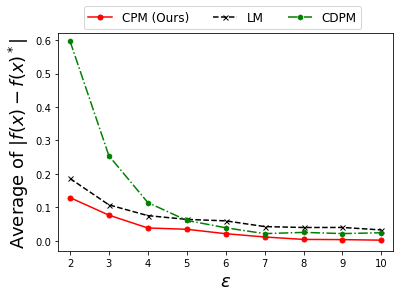

In [6]:
m = 2

diff = np.zeros((9,3))
max_diff = np.zeros((9,3)); min_diff = np.zeros((9,3))
sum_diff = np.zeros((9,3))

jj = 100
for j in range(jj):
    diff = accuracy(m)
    for i in range(9):
        for k in range(3):
            max_diff[i][k] = max(max_diff[i][k], diff[i][k])
            min_diff[i][k] = min(min_diff[i][k], diff[i][k])
            sum_diff[i][k] += diff[i][k]
    print(diff)
diff = sum_diff/jj

y_err = np.zeros((2,9,3))
for k in range(3):
    y_err[0,:,k] = diff[:,k] - min_diff[:,k]
    y_err[1,:,k] = max_diff[:,k] - diff[:,k]
    
epsilon = [i+2 for i in range(9)]

print(diff)
fig = plt.figure()
plt.ylim(-0.03, 0.62)
plt.xlim(1.7, 10.3)
plt.plot(epsilon, diff[:,0], marker="o", markersize=5, color = "red", linestyle = "-", label = "CPM (Ours)")
plt.plot(epsilon, diff[:,1], marker="x", markersize=5, color = "black", linestyle = "dashed", label = "LM")
plt.plot(epsilon, diff[:,2], marker="h", markersize=5, color = "green", linestyle = "dashdot", label = "CDPM")
#plt.errorbar(epsilon, diff[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='red', markeredgecolor = "red", color='red')
#plt.errorbar(epsilon, diff[:,1], yerr = y_err[:,:,1], capsize=5, fmt='x', ecolor='black', markeredgecolor = "black", color='black')
#plt.errorbar(epsilon, diff[:,2], yerr = y_err[:,:,2], capsize=5, fmt='h', ecolor='green', markeredgecolor = "green", color='green')
plt.legend(bbox_to_anchor=(0.49, 1.02), loc='lower center', borderaxespad=0, ncol=3, fontsize=12)
plt.xlabel("$\epsilon$", fontsize = 18)
plt.ylabel("Average of $|f(x) - f(x)^*|$", fontsize = 18)
fig.savefig("Accuracy_single_m=2.png")
fig.savefig("figs/Accuracy_single_m=2.eps", bbox_inches="tight", pad_inches=0.05)